# drive 마운트, seed 고정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.cluster import MiniBatchKMeans


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 데이터 로드 및 전처리

In [ ]:
train_data  = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')

# 열 이름 변경
train_data.columns = train_data.columns.str.replace('fog_train.', '')
test_data.columns = test_data.columns.str.replace('fog_test.', '')

# 'Unnamed: 0' 열 제거
train_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

# 테스트 데이터에서 class 열 제거, 목표변수가 test데이터 열에 포함되면 안되기 때문
test_data = test_data.drop(columns=['class'], errors='ignore')

# 결측값 처리 (-99, -99.9를 NaN으로 대체)
train_data.replace([-99, -99.9], np.nan, inplace=True)
test_data.replace([-99, -99.9], np.nan, inplace=True)

In [ ]:
# hm 컬럼에서 값이 0인 경우를 1로 대체
train_data['hm'] = train_data['hm'].replace(0, 1)

# 본문

In [ ]:
# train데이터는 총 3개년의 데이터가 있는데 한 년도에 29일이 포함되어잇다.
# test데이터에는 한 년도의 데이터가 있는데 29일이 포함되어잇지 않다.


In [ ]:
train_data['year'] = train_data['year'].replace({'I': 2020, 'J': 2021, 'K': 2022})
test_data['year'] = test_data['year'].replace({'L': 2024})

In [ ]:
# 'time' 열을 'hour' 열로 변경
train_data.rename(columns={'time': 'hour'}, inplace=True)
test_data.rename(columns={'time': 'hour'}, inplace=True)

In [ ]:
# 'datetime' 열 추가
train_data['datetime'] = pd.to_datetime(train_data[['year', 'month', 'day', 'hour', 'minute']])

In [ ]:
# 'datetime' 열 추가
test_data['datetime'] = pd.to_datetime(test_data[['year', 'month', 'day', 'hour', 'minute']])

# 본문

In [ ]:
def fill_class(row):
    if pd.isna(row['class']):
        if row['vis1'] < 200:
            return 1
        elif 200 <= row['vis1'] < 500:
            return 2
        elif 500 <= row['vis1'] < 1000:
            return 3
        else:
            return 4
    else:
        return row['class']

def interpolate_and_fill(df):
    # vis1 결측치 보간
    df['vis1'] = df['vis1'].interpolate(method='time')

    # 양 끝의 결측치를 다음 값과 이전 값으로 채우기
    df['vis1'] = df['vis1'].ffill().bfill()

    # vis1 값을 바탕으로 class 결측값 대체
    df['class'] = df.apply(fill_class, axis=1)

    # vis1, class 열을 제외한 나머지 수치형 변수들에 대해 결측치 보간
    numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(['vis1', 'class'])
    df[numerical_cols] = df[numerical_cols].interpolate(method='time')

    # 양 끝의 결측치를 다음 값과 이전 값으로 채우기
    df[numerical_cols] = df[numerical_cols].ffill().bfill()

    return df

In [ ]:
def interpolate_and_fill_test(df):
# vis1, class 열을 제외한 나머지 수치형 변수들에 대해 결측치 보간
    numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(['vis1', 'class'])
    df[numerical_cols] = df[numerical_cols].interpolate(method='time')

    # 양 끝의 결측치를 다음 값과 이전 값으로 채우기
    df[numerical_cols] = df[numerical_cols].ffill().bfill()

    return df

In [ ]:
# test 데이터의 결측치를 보간
grouped_1 = test_data.groupby('stn_id')
interpolated_data_1 = []

for name, group in grouped_1:
    print(f"Processing region (interpolation): {name}")

    group = group.set_index('datetime')
    group = group.interpolate()  # 결측치 보간
    interpolated_data_1.append(group.reset_index())

# 보간된 데이터프레임을 다시 하나의 데이터프레임으로 합침
interpolated_test_data = pd.concat(interpolated_data_1)
interpolated_test_data

Processing region (interpolation): AI
Processing region (interpolation): BE
Processing region (interpolation): CC
Processing region (interpolation): DD
Processing region (interpolation): ED


,datetime,year,month,day,hour,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts
0,2024-01-01 00:00:00,2024,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6
1,2024-01-01 00:10:00,2024,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6
2,2024-01-01 00:20:00,2024,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7
3,2024-01-01 00:30:00,2024,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6
4,2024-01-01 00:40:00,2024,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2024-12-31 23:10:00,2024,12,31,23,10,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9
52556,2024-12-31 23:20:00,2024,12,31,23,20,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9
52557,2024-12-31 23:30:00,2024,12,31,23,30,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8
52558,2024-12-31 23:40:00,2024,12,31,23,40,ED,322.0,3.7,4.3,0.0,72.5,0.0,1.4


In [ ]:
# 1. train결측치 보간
grouped = train_data.groupby('stn_id')
interpolated_data = []

for name, group in grouped:
    print(f"Processing region (interpolation): {name}")

    group = group.set_index('datetime')
    group = interpolate_and_fill(group)
    interpolated_data.append(group.reset_index())

# 보간된 데이터프레임을 다시 하나의 데이터프레임으로 합침
interpolated_train_data = pd.concat(interpolated_data)

Processing region (interpolation): AA
Processing region (interpolation): AB
Processing region (interpolation): AC
Processing region (interpolation): AD
Processing region (interpolation): AE
Processing region (interpolation): AF
Processing region (interpolation): AG
Processing region (interpolation): AH
Processing region (interpolation): BA
Processing region (interpolation): BB
Processing region (interpolation): BC
Processing region (interpolation): BD
Processing region (interpolation): CA
Processing region (interpolation): CB
Processing region (interpolation): DA
Processing region (interpolation): DB
Processing region (interpolation): DC
Processing region (interpolation): EA
Processing region (interpolation): EB
Processing region (interpolation): EC


# 삼각

In [ ]:
# 삼각함수를 사용한 시계열 특성 생성 함수
def create_sin_cos_features(df):
    # 시간 단위로 변환
    df['seconds_in_day'] = df['hour'] * 3600 + df['minute'] * 60
    df['seconds_in_year'] = (df['datetime'] - pd.to_datetime(df['datetime'].dt.year.astype(str) + '-01-01')).dt.total_seconds()

    # 하루를 기준으로 시간(hour, minute) 변환
    df['time_sin'] = np.sin(2 * np.pi * df['seconds_in_day'] / 86400)
    df['time_cos'] = np.cos(2 * np.pi * df['seconds_in_day'] / 86400)

    # 1년을 기준으로 시간(year, month, day) 변환
    df['yearly_time_sin'] = np.sin(2 * np.pi * df['seconds_in_year'] / (365 * 86400))
    df['yearly_time_cos'] = np.cos(2 * np.pi * df['seconds_in_year'] / (365 * 86400))

    return df


In [ ]:

# 시계열 특성 생성
interpolated_train_data_t = create_sin_cos_features(interpolated_train_data)

print("\nFinal DataFrame with Sin and Cos Features:")
print(interpolated_train_data_t[['datetime', 'time_sin', 'time_cos', 'yearly_time_sin', 'yearly_time_cos']].head())


Final DataFrame with Sin and Cos Features:
             datetime  time_sin  time_cos  yearly_time_sin  yearly_time_cos
0 2020-01-01 00:10:00  0.043619  0.999048         0.000120              1.0
1 2020-01-01 00:20:00  0.087156  0.996195         0.000239              1.0
2 2020-01-01 00:30:00  0.130526  0.991445         0.000359              1.0
3 2020-01-01 00:40:00  0.173648  0.984808         0.000478              1.0
4 2020-01-01 00:50:00  0.216440  0.976296         0.000598              1.0


In [ ]:

# 시계열 특성 생성
interpolated_test_data_t = create_sin_cos_features(interpolated_test_data)

print("\nFinal DataFrame with Sin and Cos Features:")
print(interpolated_test_data_t[['datetime', 'time_sin', 'time_cos', 'yearly_time_sin', 'yearly_time_cos']].head())


Final DataFrame with Sin and Cos Features:
             datetime  time_sin  time_cos  yearly_time_sin  yearly_time_cos
0 2024-01-01 00:00:00  0.000000  1.000000         0.000000              1.0
1 2024-01-01 00:10:00  0.043619  0.999048         0.000120              1.0
2 2024-01-01 00:20:00  0.087156  0.996195         0.000239              1.0
3 2024-01-01 00:30:00  0.130526  0.991445         0.000359              1.0
4 2024-01-01 00:40:00  0.173648  0.984808         0.000478              1.0


In [ ]:
interpolated_train_data_t.isnull().sum()

datetime              0
year                  0
month                 0
day                   0
hour                  0
minute                0
stn_id                0
ws10_deg              0
ws10_ms               0
ta                    0
re                    0
hm                    0
sun10                 0
ts                    0
vis1                  0
class                 0
seconds_in_day        0
seconds_in_year       0
time_sin              0
time_cos              0
yearly_time_sin       0
yearly_time_cos       0
Temp_Diff             0
dew_point             0
dew_point_minus_ta    0
sqrt_rounded_diff     0
ws10_deg_sin          0
ws10_deg_cos          0
dtype: int64

In [ ]:
interpolated_test_data_t.isnull().sum()

datetime               0
year                   0
month                  0
day                    0
hour                   0
minute                 0
stn_id                 0
ws10_deg               0
ws10_ms                0
ta                     0
re                     0
hm                     0
sun10                  0
ts                    54
seconds_in_day         0
seconds_in_year        0
time_sin               0
time_cos               0
yearly_time_sin        0
yearly_time_cos        0
Temp_Diff             54
dew_point              0
dew_point_minus_ta     0
sqrt_rounded_diff      0
ws10_deg_sin           0
ws10_deg_cos           0
dtype: int64

# 풍향(이제는 더미가된...)

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 각도 범위를 4개 방향으로 나누는 함수
def degree_to_direction(deg):
    if (337.5 <= deg <= 360) or (0 <= deg < 45) or (315 <= deg < 337.5):
        return 'N'
    elif 45 <= deg < 135:
        return 'E'
    elif 135 <= deg < 225:
        return 'S'
    elif 225 <= deg < 315:
        return 'W'
    else:
        return 'Unknown'

In [ ]:

# 각도 데이터를 방향으로 변환하기 전에 float으로 변환
interpolated_train_data_t['ws10_deg'] = interpolated_train_data_t['ws10_deg'].astype(float)


# 각도 데이터를 방향으로 변환
interpolated_train_data_t['ws10_deg'] = interpolated_train_data_t['ws10_deg'].apply(degree_to_direction)

In [ ]:

# 각도 데이터를 방향으로 변환하기 전에 float으로 변환
interpolated_test_data_t['ws10_deg'] = interpolated_test_data_t['ws10_deg'].astype(float)


# 각도 데이터를 방향으로 변환
interpolated_test_data_t['ws10_deg'] = interpolated_test_data_t['ws10_deg'].apply(degree_to_direction)

In [ ]:
interpolated_train_data_t

,datetime,year,month,day,hour,minute,stn_id,ws10_deg,ws10_ms,ta,...,sun10,ts,vis1,class,seconds_in_day,seconds_in_year,time_sin,time_cos,yearly_time_sin,yearly_time_cos
0,2020-01-01 00:10:00,2020,1,1,0,10,AA,N,0.0,-6.4,...,0.0,-2.8,20000.0,4.0,600,600.0,0.043619,0.999048,0.000120,1.0
1,2020-01-01 00:20:00,2020,1,1,0,20,AA,N,0.0,-6.3,...,0.0,-2.7,20000.0,4.0,1200,1200.0,0.087156,0.996195,0.000239,1.0
2,2020-01-01 00:30:00,2020,1,1,0,30,AA,N,0.0,-6.3,...,0.0,-2.6,20000.0,4.0,1800,1800.0,0.130526,0.991445,0.000359,1.0
3,2020-01-01 00:40:00,2020,1,1,0,40,AA,N,0.4,-6.2,...,0.0,-2.6,20000.0,4.0,2400,2400.0,0.173648,0.984808,0.000478,1.0
4,2020-01-01 00:50:00,2020,1,1,0,50,AA,E,0.5,-6.1,...,0.0,-2.5,20000.0,4.0,3000,3000.0,0.216440,0.976296,0.000598,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157817,2022-12-31 23:10:00,2022,12,31,23,10,EC,W,7.7,2.5,...,0.0,-0.9,20000.0,4.0,83400,31533000.0,-0.216440,0.976296,-0.000598,1.0
157818,2022-12-31 23:20:00,2022,12,31,23,20,EC,W,5.7,2.3,...,0.0,-1.3,20000.0,4.0,84000,31533600.0,-0.173648,0.984808,-0.000478,1.0
157819,2022-12-31 23:30:00,2022,12,31,23,30,EC,W,4.9,2.2,...,0.0,-1.4,20000.0,4.0,84600,31534200.0,-0.130526,0.991445,-0.000359,1.0
157820,2022-12-31 23:40:00,2022,12,31,23,40,EC,W,4.6,2.1,...,0.0,-1.6,20000.0,4.0,85200,31534800.0,-0.087156,0.996195,-0.000239,1.0


In [ ]:

# 시간대를 나누는 함수 정의
def assign_time_period(hour):
    if 0 <= hour <= 8:
        return 1  # High Frequency
    else:
        return 0  # Low Frequency



In [ ]:
interpolated_train_data_t['time_period'] = interpolated_train_data_t['hour'].apply(assign_time_period)

In [ ]:
interpolated_train_data_t

,datetime,year,month,day,hour,minute,stn_id,ws10_deg,ws10_ms,ta,...,ts,vis1,class,seconds_in_day,seconds_in_year,time_sin,time_cos,yearly_time_sin,yearly_time_cos,time_period
0,2020-01-01 00:10:00,2020,1,1,0,10,AA,N,0.0,-6.4,...,-2.8,20000.0,4.0,600,600.0,0.043619,0.999048,0.000120,1.0,1
1,2020-01-01 00:20:00,2020,1,1,0,20,AA,N,0.0,-6.3,...,-2.7,20000.0,4.0,1200,1200.0,0.087156,0.996195,0.000239,1.0,1
2,2020-01-01 00:30:00,2020,1,1,0,30,AA,N,0.0,-6.3,...,-2.6,20000.0,4.0,1800,1800.0,0.130526,0.991445,0.000359,1.0,1
3,2020-01-01 00:40:00,2020,1,1,0,40,AA,N,0.4,-6.2,...,-2.6,20000.0,4.0,2400,2400.0,0.173648,0.984808,0.000478,1.0,1
4,2020-01-01 00:50:00,2020,1,1,0,50,AA,E,0.5,-6.1,...,-2.5,20000.0,4.0,3000,3000.0,0.216440,0.976296,0.000598,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157817,2022-12-31 23:10:00,2022,12,31,23,10,EC,W,7.7,2.5,...,-0.9,20000.0,4.0,83400,31533000.0,-0.216440,0.976296,-0.000598,1.0,0
157818,2022-12-31 23:20:00,2022,12,31,23,20,EC,W,5.7,2.3,...,-1.3,20000.0,4.0,84000,31533600.0,-0.173648,0.984808,-0.000478,1.0,0
157819,2022-12-31 23:30:00,2022,12,31,23,30,EC,W,4.9,2.2,...,-1.4,20000.0,4.0,84600,31534200.0,-0.130526,0.991445,-0.000359,1.0,0
157820,2022-12-31 23:40:00,2022,12,31,23,40,EC,W,4.6,2.1,...,-1.6,20000.0,4.0,85200,31534800.0,-0.087156,0.996195,-0.000239,1.0,0


In [ ]:
interpolated_test_data_t['time_period'] = interpolated_test_data_t['hour'].apply(assign_time_period)

# 파생변수

In [ ]:
interpolated_train_data_t['Temp_Diff'] = interpolated_train_data_t['ta'] - interpolated_train_data_t['ts']
interpolated_test_data_t['Temp_Diff'] = interpolated_test_data_t['ta'] - interpolated_test_data_t['ts']

In [ ]:
#interpolated_train_data_t['Fog_Likelihood_Index'] = (interpolated_train_data_t['Temp_Diff'] * interpolated_train_data_t['hm']) / (interpolated_train_data_t['ws10_ms'] + 1)
#interpolated_test_data_t['Fog_Likelihood_Index'] = (interpolated_test_data_t['Temp_Diff'] * interpolated_test_data_t['hm']) / (interpolated_test_data_t['ws10_ms'] + 1)

In [ ]:
import pandas as pd
import numpy as np

# 매그너스 공식의 상수
a = 17.62
b = 243.12

# 이슬점 계산 함수
def calculate_dew_point(temperature, humidity):
    gamma = (a * temperature) / (b + temperature) + np.log(humidity / 100.0)
    dew_point = (b * gamma) / (a - gamma)
    return dew_point


In [ ]:
# 이슬점 온도 계산 및 컬럼 추가
interpolated_train_data_t['dew_point'] = interpolated_train_data_t.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [ ]:
interpolated_test_data_t['dew_point'] = interpolated_test_data_t.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [ ]:
interpolated_train_data_t['dew_point_minus_ta'] = -(interpolated_train_data_t['dew_point'] - interpolated_train_data_t['ta']).round(1)

In [ ]:
interpolated_test_data_t['dew_point_minus_ta'] = -(interpolated_test_data_t['dew_point'] - interpolated_test_data_t['ta']).round(1)

In [ ]:
interpolated_train_data_t['sqrt_rounded_diff'] = np.sqrt(interpolated_train_data_t['dew_point_minus_ta'])

In [ ]:
interpolated_test_data_t['sqrt_rounded_diff'] = np.sqrt(interpolated_test_data_t['dew_point_minus_ta'])

In [ ]:
# 풍향을 주기적인 특성으로 변환하는 함수
def transform_wind_direction(df):
    df['ws10_deg_sin'] = np.sin(np.deg2rad(df['ws10_deg']))
    df['ws10_deg_cos'] = np.cos(np.deg2rad(df['ws10_deg']))
    return df

# 데이터프레임에 변환 적용
interpolated_train_data = transform_wind_direction(interpolated_train_data)

# 결과 출력
print(interpolated_train_data[['ws10_deg', 'ws10_deg_sin', 'ws10_deg_cos']])


# 풍향을 주기적인 특성으로 변환하는 함수
def transform_wind_direction(df):
    df['ws10_deg_sin'] = np.sin(np.deg2rad(df['ws10_deg']))
    df['ws10_deg_cos'] = np.cos(np.deg2rad(df['ws10_deg']))
    return df

# 데이터프레임에 변환 적용
interpolated_test_data = transform_wind_direction(interpolated_test_data)

# 결과 출력
print(interpolated_test_data[['ws10_deg', 'ws10_deg_sin', 'ws10_deg_cos']])


        ws10_deg  ws10_deg_sin  ws10_deg_cos
0            0.0      0.000000      1.000000
1            0.0      0.000000      1.000000
2            0.0      0.000000      1.000000
3           27.8      0.466387      0.884581
4           59.7      0.863396      0.504528
...          ...           ...           ...
157817     305.3     -0.816138      0.577858
157818     293.8     -0.914960      0.403545
157819     274.2     -0.997314      0.073238
157820     270.3     -0.999986      0.005236
157821     254.8     -0.965016     -0.262189

[3156459 rows x 3 columns]
       ws10_deg  ws10_deg_sin  ws10_deg_cos
0         329.5     -0.507538      0.861629
1         321.8     -0.618408      0.785857
2           0.4      0.006981      0.999976
3         323.6     -0.593419      0.804894
4         208.4     -0.475624     -0.879649
...         ...           ...           ...
52555     338.8     -0.361625      0.932324
52556     335.2     -0.419452      0.907777
52557     337.1     -0.389124      0

# 시계

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import xgboost as xgb

# 시계열 특성 생성 함수 정의
def create_time_series_features(df):
    # 이동 평균
    df['sqrt_rounded_diff_rolling_mean_30m'] = df['sqrt_rounded_diff'].rolling(window=3, min_periods=1).mean()  # 30분 이동 평균 (10분 간격 데이터)
    df['sqrt_rounded_diff_rolling_mean_1h'] = df['sqrt_rounded_diff'].rolling(window=6, min_periods=1).mean()   # 1시간 이동 평균 (10분 간격 데이터)
    df['sqrt_rounded_diff_rolling_mean_3h'] = df['sqrt_rounded_diff'].rolling(window=18, min_periods=1).mean()  # 3시간 이동 평균 (10분 간격 데이터)

    # 이동 표준편차
    df['sqrt_rounded_diff_rolling_std_30m'] = df['sqrt_rounded_diff'].rolling(window=3, min_periods=1).std()    # 30분 이동 표준편차
    df['sqrt_rounded_diff_rolling_std_1h'] = df['sqrt_rounded_diff'].rolling(window=6, min_periods=1).std()     # 1시간 이동 표준편차
    df['sqrt_rounded_diff_rolling_std_3h'] = df['sqrt_rounded_diff'].rolling(window=18, min_periods=1).std()    # 3시간 이동 표준편차

    # 시간 지연 변수
    df['sqrt_rounded_diff_lag_1'] = df['sqrt_rounded_diff'].shift(1)  # 10분 이전 값
    df['sqrt_rounded_diff_lag_3'] = df['sqrt_rounded_diff'].shift(3)  # 30분 이전 값
    df['sqrt_rounded_diff_lag_6'] = df['sqrt_rounded_diff'].shift(6)  # 1시간 이전 값
    df['sqrt_rounded_diff_lag_18'] = df['sqrt_rounded_diff'].shift(18)  # 3시간 이전 값


    df['ws10_deg_sin_rolling_mean_1h'] = df['ws10_deg_sin'].rolling(window=6, min_periods=1).mean()  # 1시간 이동 평균 (10분 간격 데이터)
    df['ws10_deg_sin_rolling_mean_3h'] = df['ws10_deg_sin'].rolling(window=18, min_periods=1).mean()  # 3시간 이동 평균 (10분 간격 데이터)

    return df



In [ ]:
# 데이터프레임 생성 (기존 데이터프레임을 사용하여 새로운 데이터프레임 생성)
train_data = interpolated_train_data_t.copy()
test_data = interpolated_test_data_t.copy()  # 테스트 데이터의 예시

# 지역별로 시계열 특성 생성 및 결측치 처리
train_data_list = []
test_data_list = []

for region in train_data['stn_id'].unique():
    # 훈련 데이터에 시계열 특성 생성
    train_region_data = train_data[train_data['stn_id'] == region].copy()
    train_region_data = create_time_series_features(train_region_data)
    train_region_data = train_region_data.dropna()  # 결측치 제거
    train_data_list.append(train_region_data)

for region in test_data['stn_id'].unique():
    # 테스트 데이터에 시계열 특성 생성
    test_region_data = test_data[test_data['stn_id'] == region].copy()
    test_region_data = create_time_series_features(test_region_data)
    test_region_data = test_region_data.fillna(method='bfill').fillna(method='ffill')  # 결측치 보간
    test_data_list.append(test_region_data)


In [ ]:
# 리스트를 데이터프레임으로 결합
train_data_final = pd.concat(train_data_list)
test_data_final = pd.concat(test_data_list)

# 축약

In [ ]:
###
###
### 이상치제거 feature 만들

In [ ]:
# 필요 없는 열 제거
columns_to_drop = ['datetime', 'month', 'day', 'hour', 'minute', 'seconds_in_day', 'seconds_in_year','dew_point_minus_ta', 'dew_point','ts',
                   're', 'sqrt_rounded_diff_lag_1', 'sqrt_rounded_diff', 'sqrt_rounded_diff_lag_3', 'sqrt_rounded_diff_rolling_mean_30m',
                   'sqrt_rounded_diff_lag_6','sun10', 'sqrt_rounded_diff_rolling_mean_1h', 'sqrt_rounded_diff_rolling_std_30m', 'sqrt_rounded_diff_lag_18', 'ws10_deg', 'sqrt_rounded_diff_rolling_std_1h']

train_data_final_drop = train_data_final.drop(columns=columns_to_drop)
# 필요 없는 열 제거
test_data_final_drop = test_data_final.drop(columns=columns_to_drop)

In [ ]:
train_data_final_drop.shape

(3156099, 18)

In [ ]:
test_data_final_drop.shape

(262800, 16)

In [ ]:
import pandas as pd

# 검증용 데이터로 사용할 (year, 지역) 목록
val_regions = [
    ('AA', 2020),
    ('EC', 2021),
    ('DA', 2022),
    ('BB', 2022),
    ('CA', 2022),
    ('AB', 2021),
    ('AD', 2022),
    ('BA', 2020),
    ('DB', 2021)
]

# year와 지역 조건에 맞는 데이터 필터링
conditions = [(train_data_final_drop['stn_id'] == stn_id) & (train_data_final_drop['year'] == year) for stn_id, year in val_regions]
val_condition = conditions[0]
for condition in conditions[1:]:
    val_condition |= condition

train_df_A3_val = train_data_final_drop[val_condition]
train_df_A3_train = train_data_final_drop[~val_condition]

In [ ]:
train_df_A3_val

,ws10_ms,ta,hm,vis1,class,time_sin,time_cos,yearly_time_sin,yearly_time_cos,Temp_Diff,ws10_deg_sin,ws10_deg_cos,sqrt_rounded_diff_rolling_mean_3h,sqrt_rounded_diff_rolling_std_3h,ws10_deg_sin_rolling_mean_1h,ws10_deg_sin_rolling_mean_3h
18,0.0,-5.6,46.3,19165.0,4.0,0.737277,0.675590,0.002271,0.999997,-3.0,0.653421,0.756995,3.296522,0.106548,0.275629,0.326570
19,0.0,-5.6,46.0,20000.0,4.0,0.766044,0.642788,0.002391,0.999997,-3.1,0.000000,1.000000,3.277188,0.103102,0.171877,0.326570
20,0.0,-5.5,47.0,20000.0,4.0,0.793353,0.608761,0.002510,0.999997,-3.0,0.000000,1.000000,3.261743,0.108070,0.108903,0.326570
21,0.0,-5.4,48.5,20000.0,4.0,0.819152,0.573576,0.002630,0.999997,-3.0,0.000000,1.000000,3.241036,0.114355,0.108903,0.300660
22,0.0,-5.5,46.5,20000.0,4.0,0.843391,0.537300,0.002749,0.999996,-3.1,0.000000,1.000000,3.225665,0.111549,0.108903,0.252693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105257,7.1,-2.3,47.4,20000.0,4.0,-0.216440,0.976296,-0.000598,1.000000,0.6,-0.733730,0.679441,3.103581,0.034458,-0.740959,-0.713770
105258,7.2,-2.3,46.3,20000.0,4.0,-0.173648,0.984808,-0.000478,1.000000,0.7,-0.703395,0.710799,3.102704,0.032603,-0.733946,-0.714256
105259,7.2,-2.3,45.5,20000.0,4.0,-0.130526,0.991445,-0.000359,1.000000,0.6,-0.699663,0.714473,3.106218,0.038627,-0.726310,-0.712166
105260,7.2,-2.3,44.6,20000.0,4.0,-0.087156,0.996195,-0.000239,1.000000,0.7,-0.739631,0.673013,3.112322,0.049765,-0.724371,-0.713226


#XGBOOST

In [ ]:
train_df_A3_train = train_df_A3_train.drop('stn_id', axis=1)
train_df_A3_val = train_df_A3_val.drop('stn_id', axis=1)

In [ ]:
train_df_A3_train = train_df_A3_train.drop('year', axis=1)
train_df_A3_val = train_df_A3_val.drop('year', axis=1)

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# 특징과 라벨 분리 (훈련 데이터)
X_train_final = train_df_A3_train.drop(['class', 'vis1'], axis=1)
y_train_final = train_df_A3_train['class']

X_val = train_df_A3_val.drop(['class', 'vis1'], axis=1)
y_val = train_df_A3_val['class']


In [ ]:
# 클래스 라벨을 0부터 시작하도록 변환 (라벨 값이 1부터 시작하는 경우)
y_train_final = y_train_final - y_train_final.min()
y_val = y_val - y_val.min()

# 라벨 값이 0부터 num_class-1 사이에 있는지 확인
assert y_train_final.min() >= 0 and y_train_final.max() < 4, "Train labels must be in the range [0, num_class)."
assert y_val.min() >= 0 and y_val.max() < 4, "Validation labels must be in the range [0, num_class)."

In [ ]:


# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_final), y=y_train_final)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train_final), class_weights)}

# 가중치 부여
weights = np.array([class_weights[label] for label in y_train_final])

# DMatrix 생성
dtrain = xgb.DMatrix(X_train_final, label=y_train_final, weight=weights)
dval = xgb.DMatrix(X_val, label=y_val)


In [ ]:

# XGBoost 모델 학습
param = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'eta': 0.3,
    'max_depth': 6,
    'seed': 42
}

num_round = 1000
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# 검증 데이터에 대한 예측
y_val_pred = bst.predict(dval)



[0]	eval-mlogloss:1.08099	train-mlogloss:1.25072
[1]	eval-mlogloss:0.90871	train-mlogloss:1.16544
[2]	eval-mlogloss:0.80197	train-mlogloss:1.10808
[3]	eval-mlogloss:0.72553	train-mlogloss:1.06357
[4]	eval-mlogloss:0.67245	train-mlogloss:1.02835
[5]	eval-mlogloss:0.63155	train-mlogloss:1.00047
[6]	eval-mlogloss:0.60299	train-mlogloss:0.97856
[7]	eval-mlogloss:0.58308	train-mlogloss:0.96077
[8]	eval-mlogloss:0.56638	train-mlogloss:0.94509
[9]	eval-mlogloss:0.55363	train-mlogloss:0.93040
[10]	eval-mlogloss:0.54221	train-mlogloss:0.91938
[11]	eval-mlogloss:0.53436	train-mlogloss:0.90919
[12]	eval-mlogloss:0.52885	train-mlogloss:0.90014
[13]	eval-mlogloss:0.52319	train-mlogloss:0.89102
[14]	eval-mlogloss:0.51985	train-mlogloss:0.88202
[15]	eval-mlogloss:0.51477	train-mlogloss:0.87374
[16]	eval-mlogloss:0.50912	train-mlogloss:0.86448
[17]	eval-mlogloss:0.50582	train-mlogloss:0.85927
[18]	eval-mlogloss:0.50211	train-mlogloss:0.85462
[19]	eval-mlogloss:0.49721	train-mlogloss:0.84776
[20]	eval-

In [ ]:
# 최종 평가
y_val = y_val
y_val_pred = y_val_pred +1

In [ ]:
# 혼동 행렬 계산
cm_val = confusion_matrix(y_val, y_val_pred, labels=[1, 2, 3, 4])


# 혼동 행렬 출력
print("Confusion Matrix for Validation Data:")
print(cm_val)


# 검증 데이터의 다중 CSI 계산
H_val = cm_val[0, 0] + cm_val[1, 1] + cm_val[2, 2]  # H11, H22, H33
F_val = (cm_val[0, 1] + cm_val[0, 2] + cm_val[1, 0] +
         cm_val[1, 2] + cm_val[2, 0] + cm_val[2, 1] +
         cm_val[3, 0] + cm_val[3, 1] + cm_val[3, 2])  # F12, F13, F21, F23, F31, F32, F41, F42, F43
M_val = cm_val[0, 3] + cm_val[1, 3] + cm_val[2, 3]  # M14, M24, M34

CSI_val = H_val / (H_val + F_val + M_val)
print(f"CSI for Validation Data: {CSI_val:.2f}")

Confusion Matrix for Validation Data:
[[   158    178    157    753]
 [    85    282    245   1027]
 [    49    142    303   1308]
 [   721   1700   3847 462334]]
CSI for Validation Data: 0.07


Feature Importance:
                              Feature  Importance
3                                  ta     16801.0
16       ws10_deg_sin_rolling_mean_3h     15641.0
9                           Temp_Diff     15396.0
7                     yearly_time_sin     14208.0
15       ws10_deg_sin_rolling_mean_1h     14169.0
14   sqrt_rounded_diff_rolling_std_3h     13613.0
4                                  hm     13373.0
8                     yearly_time_cos     12811.0
12  sqrt_rounded_diff_rolling_mean_3h     12639.0
5                            time_sin     12581.0
6                            time_cos     12507.0
2                             ws10_ms     11859.0
11                       ws10_deg_cos     10346.0
10                       ws10_deg_sin     10323.0
13   sqrt_rounded_diff_rolling_std_1h      9397.0
1                            ws10_deg      7980.0
0                                year      2715.0


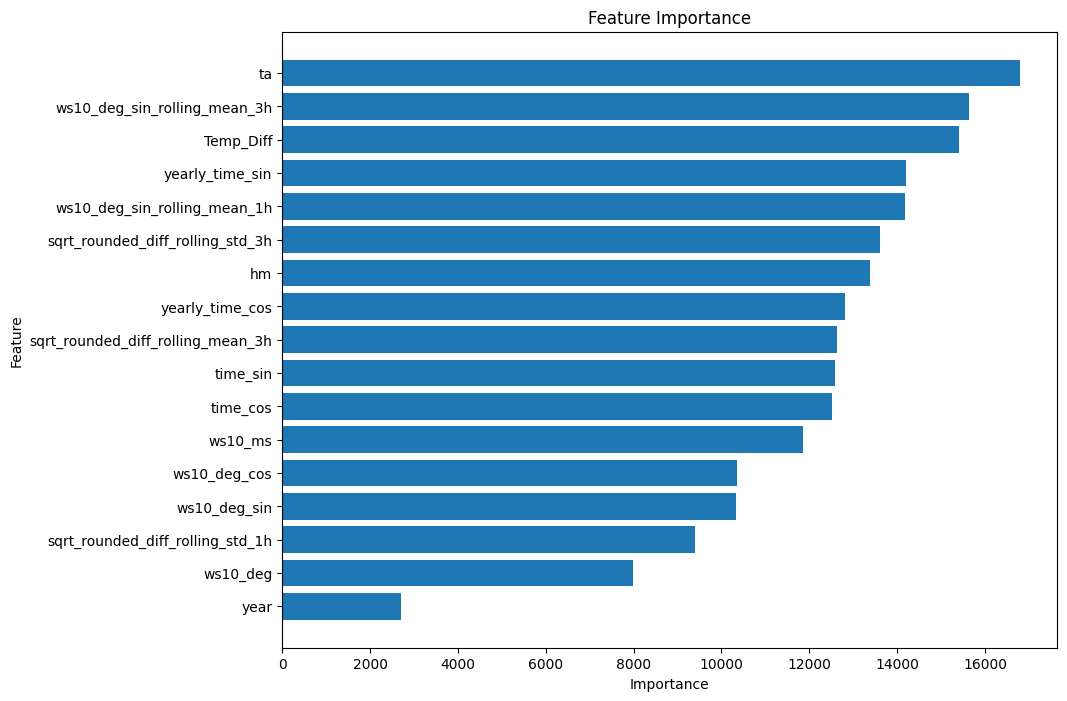

In [ ]:
# Feature importance 구하기
importance = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# 중요도 내림차순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# feature importance 출력
print("Feature Importance:")
print(importance_df)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# 각 컬럼에 의미를 부여...
# 풀어쓰기
# shap로 선 부넉 후 도메인 적용

In [ ]:
# 테스트 데이터 예측
dtest = xgb.DMatrix(test_data_final_encoded)
y_test_pred = bst.predict(dtest)



In [ ]:
# y_test_pred 값별 비율 계산
unique, counts = np.unique(y_test_pred, return_counts=True)
ratios = counts / counts.sum()

# 값과 비율 출력
for value, ratio in zip(unique, ratios):
    print(f"Value: {value}, Ratio: {ratio:.9f}")

Value: 0.0, Ratio: 0.002279300
Value: 1.0, Ratio: 0.010422374
Value: 2.0, Ratio: 0.011662861
Value: 3.0, Ratio: 0.975635464


In [ ]:

# 예측 결과를 원래 클래스 라벨로 변환
y_test_pred = y_test_pred.astype(int) + 1

# 제출하기 위해 test데이터 다시 불러옴
sub_test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')
sub_test_data = sub_test_data.drop(columns=['fog_test.class'], errors='ignore')

# 예측 결과를 데이터프레임으로 저장
sub_test_data['fog_test.class'] = y_test_pred

# 예측 결과 저장
sub_test_data.to_csv('240184.csv', index=False)
sub_test_data["fog_test.class"].value_counts()

fog_test.class
4    256397
3      3065
2      2739
1       599
Name: count, dtype: int64

In [ ]:
# 파일 다운로드
from google.colab import files
files.download('240184.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>